## Landmark Classification & Tagging

### Introduction

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, classification & Tagging model is built to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, it will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world.




###  Dataset and Required Python Modules

In the project a subset of Google's Landmark Detection dataset is used. The dataset can be accessed [here]().

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

###  CNN to Classify Landmarks

In this step, a CNN has been built that classifies landmarks _from scratch_ and strived to attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would one have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. 

### Data Loaders for the Landmark Dataset

In below code cell three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) have been created: one for training data, one for validation data, and one for test data.


All three of data loaders are accessible via a dictionary named `loaders_scratch`. Train data loader is at `loaders_scratch['train']`, Validation data loader is at `loaders_scratch['valid']`, and Test data loader is at `loaders_scratch['test']`.

If needed can be found [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [19]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

# percentage of training set to use as validation
valid_size = 0.2
# define dataloader parameters
batch_size  = 50
num_workers = 0

# define training and test data directories
data_dir  = '/data/landmark_images/'
train_dir = os.path.join(data_dir, 'train') 
test_dir  = os.path.join(data_dir, 'test') 

# load and transform data using ImageFolder
data_transform = transforms.Compose([transforms.Resize(32),
                                     transforms.CenterCrop(32),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data  = datasets.ImageFolder(test_dir, transform=data_transform)

# split indices in two groups that will be used for training  and validation
train_data_len = len(train_data)
train_data_indices = list(range(train_data_len)) # seems we cant use enumerate here, at least i :-/
np.random.shuffle(train_data_indices)
valid_indices,train_indices = np.split(train_data_indices, [int(train_data_len*valid_size)])

## print out some data stats
print('Num training images: ',   len(train_indices))
print('Num validation images: ', len(valid_indices))
print('Num test images: ',       len(test_data))

# use samplers for training and validation batches
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader  = torch.utils.data.DataLoader(test_data,  batch_size=batch_size, shuffle=True,          num_workers=num_workers)

loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

Num training images:  3997
Num validation images:  999
Num test images:  1250


### Visualize a Batch of Training Data

Below code cell is to retrieve a batch of images from train data loader, to display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

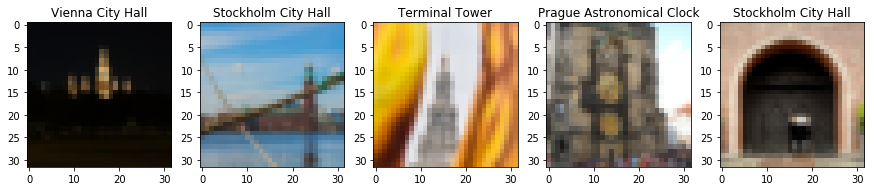

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline


# list of class names by index, i.e. a name can be accessed like class_names[0]
classes = [item[3:].replace("_", " ") for item in train_data.classes]

# access images and convert to numpy for display
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() 

# plot the images with labels
fig = plt.figure()
fig.set_size_inches(15, 15)
for i in np.arange(5):
    ax = fig.add_subplot(1, 5, i+1)
    plt.imshow(np.transpose(images[i]/2+0.5, (1, 2, 0)))  # unnormalize + convert from Tensor image
    ax.set_title(classes[labels[i]])


### Check access to GPU

In [3]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

###  Specify Loss Function and Optimizer

Next cell is to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).

In [4]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# specify loss function
criterion_scratch = nn.CrossEntropyLoss() 

def get_optimizer_scratch(model):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    return optimizer

### Model Architecture

CNN Architecture to classify images of landmarks.

In [5]:
# import torch.nn as nn # moved to the above block, cause i need it for loss function!

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN

        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # cl 1 sees 32x32x3 image tensor
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # cl 2 sees 16x16x16 tensor
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) # cl 3 sees 8x8x32 tensor
        self.pool = nn.MaxPool2d(2, 2)               # max pooling layer for the downsmapling 32 -> 16 -> 8       
        self.fc1 = nn.Linear(64 * 4 * 4, 500)        # ll 1 computes class scores 64 * 4 * 4 -> 500
        self.fc2 = nn.Linear(500, 50)                # ll 2 computes class scores 500 -> 50
        self.dropout = nn.Dropout(0.25)              # dl with factor p=0.25

    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))         # add sequence of convolutional, relu and max pooling layers
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))        
        x = x.view(-1, 64 * 4 * 4)                   # flatten image input        
        x = self.dropout(x)                          # add dropout layer        
        x = F.relu(self.fc1(x))                      # add hidden fc layer, with relu activation function        
        x = self.dropout(x)                          # add dropout layer        
        x = self.fc2(x)                              # add fc layer
        return x



# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

**Explanation Regarding above Architecture:**
- Outline of steps I took to get to our final CNN architecture and reasoning at each step.  

To better understand the network I followed the guide [here](https://cs231n.github.io/convolutional-networks/#layers).

The most common form of a ConvNet is:
* INPUT -> [[CONV -> RELU] * N -> POOL?] * M -> [FC -> RELU] * K -> FC

For the one used the paramters are the following:
* N=1 (N>=0 and N <=3)
* M=3 (M>= 0)
* K=1 (K>=0 and K<3)

So the final Network looks like this:
* INPUT -> [[CONV -> RELU] * 1 -> POOL] * 3 -> [FC -> RELU] * 1 -> FC

Additionally a dropout layer is used to prevent overfitting.

Of course the output of the final layer matches the classes, while the input matches the image size and color channels.

### Implementing the Training Algorithm

In [6]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):                        
        #or data, target in train_loader:                        
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))


            optimizer.zero_grad()            # clear the gradients of all optimized variables            
            output = model(data)             # forward pass: compute predicted outputs by passing inputs to the model            
            loss = criterion(output, target) # calculate the batch loss            
            loss.backward()                  # backward pass: compute gradient of the loss with respect to model parameters            
            optimizer.step()                 # perform a single optimization step (parameter update)            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss)) # update training loss
            
        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
        #or data, target in valid_loader:
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()


            output = model(data)             # forward pass: compute predicted outputs by passing inputs to the model            
            loss = criterion(output, target) # calculate the batch loss            
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss)) # update average validation loss 
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
        
    return model

### Experiment with the Weight Initialization

Below code cell is to define a custom weight initialization, and then train with our weight initialization for a few epochs. Here it is important to make sure that neither the training loss nor validation loss is `nan`.

In [7]:
def custom_weight_init(m):

    # takes in a module and applies the specified weight initialization
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0)   
    

# my weights dont really help the model to converge, so i reduced the epochs to 5, as its just slow ...

model_scratch.apply(custom_weight_init)
model_scratch = train(5, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 11.959802 	Validation Loss: 3.917333
Validation loss decreased (inf --> 3.917333).  Saving model ...
Epoch: 2 	Training Loss: 3.913237 	Validation Loss: 3.916664
Validation loss decreased (3.917333 --> 3.916664).  Saving model ...
Epoch: 3 	Training Loss: 3.913299 	Validation Loss: 3.916905
Epoch: 4 	Training Loss: 3.912684 	Validation Loss: 3.916715
Epoch: 5 	Training Loss: 3.912647 	Validation Loss: 3.917185


### Train and Validate the Model

In [8]:
num_epochs = 10

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=50, bias=True)
  (dropout): Dropout(p=0.25)
)

In [9]:
# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.845732 	Validation Loss: 3.746893
Validation loss decreased (inf --> 3.746893).  Saving model ...
Epoch: 2 	Training Loss: 3.615861 	Validation Loss: 3.504203
Validation loss decreased (3.746893 --> 3.504203).  Saving model ...
Epoch: 3 	Training Loss: 3.361600 	Validation Loss: 3.306246
Validation loss decreased (3.504203 --> 3.306246).  Saving model ...
Epoch: 4 	Training Loss: 3.156451 	Validation Loss: 3.205269
Validation loss decreased (3.306246 --> 3.205269).  Saving model ...
Epoch: 5 	Training Loss: 2.983609 	Validation Loss: 3.191448
Validation loss decreased (3.205269 --> 3.191448).  Saving model ...
Epoch: 6 	Training Loss: 2.809467 	Validation Loss: 3.094999
Validation loss decreased (3.191448 --> 3.094999).  Saving model ...
Epoch: 7 	Training Loss: 2.668631 	Validation Loss: 2.995188
Validation loss decreased (3.094999 --> 2.995188).  Saving model ...
Epoch: 8 	Training Loss: 2.473488 	Validation Loss: 3.015517
Epoch: 9 	Training Loss: 2.321691 

### Test the Model

Below code cell is to try out our model on the test dataset of landmark images code cell below is calculating and printing the test loss and accuracy.

In [12]:
# calculation of loss is different, there is no average used
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [13]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.845560


Test Accuracy: 28% (356/1250)


### CNN to Classify Landmarks (using Transfer Learning)

Now I will use transfer learning to create a CNN that can identify landmarks from images.Our CNN must attain at least 60% accuracy on the test set.

In [7]:
## data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# load and transform data using ImageFolder
data_transform = transforms.Compose([transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data  = datasets.ImageFolder(test_dir, transform=data_transform)

# split indices in two groups that will be used for training  and validation
train_data_len = len(train_data)
train_data_indices = list(range(train_data_len)) # seems we cant use enumerate here, at least i :-/
np.random.shuffle(train_data_indices)
valid_indices,train_indices = np.split(train_data_indices, [int(train_data_len*valid_size)])

# use samplers for training and validation batches
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader  = torch.utils.data.DataLoader(test_data,  batch_size=batch_size, shuffle=True,          num_workers=num_workers)

loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

In [8]:
import torch.nn as nn
import torch.optim as optim

criterion_transfer  = nn.CrossEntropyLoss()

def get_optimizer_transfer(model):

    optimizer = optim.SGD(model.classifier.parameters(), lr=0.001)
    
    return optimizer

### Model Architecture

Using transfer learning to create a CNN to classify images of landmarks. Below code cell is to initialize, and save the initialized model as the variable `model_transfer`.

In [9]:
import torch.nn as nn

model_transfer = models.vgg16(pretrained=True)
#print(model_transfer)

# freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False

# modify last layer to match it our classes
n_inputs = model_transfer.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model_transfer.classifier[6] = last_layer


if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 107792212.52it/s]


**Explanation Regarding above Architecture:**
- Outline of steps I took to get to our final CNN architecture, reasoning at each step and why I think the architecture is suitable for the current problem.


I decided to use the pretrained vgg16 network.

In a first step I froze the features paramters as we dont want to change the net itself. We only want to optimice the classifier to match our classes. This is important for the optimizer too.

The last layer of the network is modified. We want to keep the number of inputs, but want the output to match our classes

Again to better understand the network I followed the guide: https://cs231n.github.io/convolutional-networks/#layers

As we discused bevore the most common form of a ConvNet is:
* INPUT -> [[CONV -> RELU] * N -> POOL?] * M -> [FC -> RELU] * K -> FC

The vgg16 seems to still follow that basic form and looks like this
* INPUT -> [[CONV -> RELU] * 2 -> POOL] * 2 -> [[CONV -> RELU] * 3 -> POOL] * 3 -> [FC -> RELU] * 2 -> FC

As you can clearly see, this is a way more complex model than the one I used:
* INPUT -> [[CONV -> RELU] * 1 -> POOL] * 3 -> [FC -> RELU] * 1 -> FC

### Train and Validate the Model

In [1]:
# number of epochs to train the model
num_epochs = 10

model_scratch = train(num_epochs, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), 
                      criterion_transfer, use_cuda, 'model_transfer.pt')

NameError: name 'train' is not defined

In [14]:
# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### Test the Model

Next, Lets Try out our model on the test dataset of landmark images. Below code to calculate and print the test loss and accuracy.

In [15]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.606016


Test Accuracy: 65% (817/1250)


### Top k  Landmark Prediction

Below function `predict_landmarks`, takes a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. It is important to use our transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [16]:
import cv2
from PIL import Image

def predict_landmarks(img_path, k):
    
    # open, transform and unsqueez the image
    img = Image.open(img_path)
    img = data_transform(img)
    img.unsqueeze_(0)
    
    if use_cuda:
        img = img.cuda()

    # get k best predictions 
    output = model_transfer(img)
    _, preds_tensor = torch.topk(output,k)
    preds = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
    
    # creat an array with all the possible classes we found
    names =[]
    for pred in preds:
        names.append(classes[pred])
    
    return names
    
# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['Forth Bridge',
 'Golden Gate Bridge',
 'Sydney Harbour Bridge',
 'Brooklyn Bridge',
 'Niagara Falls']

Below function `suggest_locations`, takes a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below,
![](images/sample_landmark_output.png)

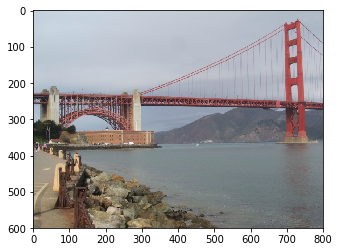

Is this pciture of the
Forth Bridge, Golden Gate Bridge, or Sydney Harbour Bridge?


In [17]:
from PIL import Image

def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    
    # show image and print caption
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    print('Is this pciture of the')
    print('%s, %s, or %s?' % (predicted_landmarks[0], predicted_landmarks[1],predicted_landmarks[2]))

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### Prediction

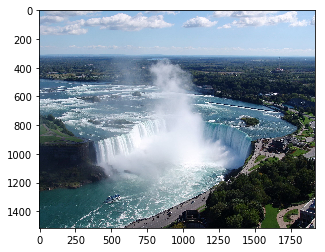

Is this pciture of the
Niagara Falls, Gullfoss Falls, or Yellowstone National Park?


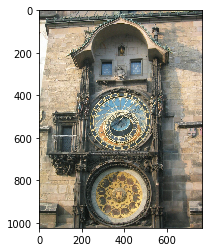

Is this pciture of the
Prague Astronomical Clock, Kantanagar Temple, or Gateway of India?


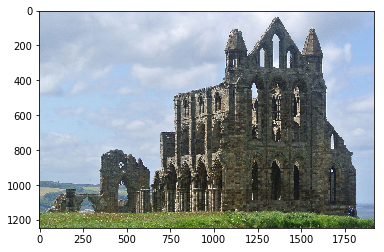

Is this pciture of the
Whitby Abbey, Edinburgh Castle, or Vienna City Hall?


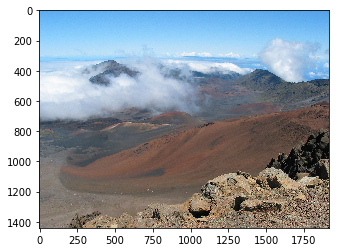

Is this pciture of the
Matterhorn, Gullfoss Falls, or Death Valley National Park?


In [18]:
import os

for filename in os.listdir('samples'):
    suggest_locations(os.path.join("samples", filename))